## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

## Setting path for reading data
   2 ways: either through google drive, or local pc path. Use the cell appropriately. Also change the paths accordingly. 
   Don't run the below 2 cells if not using on Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive
%cd CF_Data

/content/gdrive/MyDrive
/content/gdrive/MyDrive/CF_Data


## Nuclear Norm Minimization

In [68]:
def nuclear_norm_minimization(Y, lambda_, k, p):
    #initialise X
    X = np.random.rand(Y.shape[0], Y.shape[1])
    #Creating R matrix with shape of Y
    R = np.zeros(Y.shape)
    #Now putting 1s in R where Y is not 0
    R[Y!=0] = 1
    #Now iterating k times
    while(k>0):
        #Putting 0 values in R_X where R is 0
        R_X = np.multiply(R, X)
        #Calculate B
        B = X + (Y - R_X)
        U, S, V = np.linalg.svd(B, full_matrices=False)
        S = np.diag(S) 
        # Adjusting singular values using Schatten-Norm, from the given formula in paper
        sch_norm = np.sum(S ** p) ** (1 / p)
        S_ = np.maximum(0, S - ((lambda_/2)*p*(sch_norm**p)))
        
        #Updating X
        X = np.dot(U, np.dot(S_,V))
        k = k-1
    return X

In [69]:
#Calculate NMAE for the users present in the test data
def NMAE(test_data, predicted_matrix):
    test_data = test_data[test_data['rating'] > 0]  
    NMAE = 0
    for line in test_data.itertuples():
        NMAE += abs(line[3] - predicted_matrix[line[1]-1, line[2]-1])
    NMAE = NMAE / len(test_data)
    #Normalise the NMAE by the range of the ratings in the test data and return
    return NMAE / (max(test_data['rating']) - min(test_data['rating']))

## Reading Data and running for 5-folds

In [76]:
#Performing ALS on the 5 fold datasets
predicted_matrix = []
predicted_matrix_rounded = []

def NN_folds(fold_index, lambda_, max_iter, p):
    global predicted_matrix
    global predicted_matrix_rounded
    #Read the data
    train_data = pd.read_csv(f'ml-100k/u{fold_index}.base', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    test_data = pd.read_csv(f'ml-100k/u{fold_index}.test', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    #Create a matrix of users and items
    train_data_matrix = np.zeros((943, 1682))
    for line in train_data.itertuples():
        train_data_matrix[line[1]-1, line[2]-1] = line[3]
    #Predict the missing values
    predicted_matrix = nuclear_norm_minimization(train_data_matrix, lambda_, max_iter, p)
    predicted_matrix_rounded = np.round(predicted_matrix)
    #Calculate NMAE for the users present in the test data
    NMAE_ = NMAE(test_data, predicted_matrix)
    print(f'NMAE for fold {fold_index} at p {p} is: {NMAE_}')
    print(f'Rounded off-ratings: NMAE for fold {fold_index} at p {p} is: {NMAE_}')
    

## Results

For p = 0.1  Arg Order: NN_folds(fold_index, lambda_, max_iter, p)

In [74]:
NN_folds(1,0.2,20,0.1)

NMAE for fold 1 is: 0.3051678369803183
Rounded off-ratings: NMAE for fold 1 is: 0.3051678369803183


For p = 0.5

In [75]:
NN_folds(1,0.2,20,0.5)

NMAE for fold 1 is: 0.4955596620259722
Rounded off-ratings: NMAE for fold 1 is: 0.4955596620259722


For p = 1

In [77]:
NN_folds(1,0.2,100,1)

NMAE for fold 1 at p 1 is: 0.883975
Rounded off-ratings: NMAE for fold 1 at p 1 is: 0.883975


For p = 1, optimized by running on different iterations, and also algo optimization by extracting diagonals explicitly

In [79]:
NN_folds(1,0.2,30,1)

NMAE for fold 1 at p 1 is: 0.5051285714285714
Rounded off-ratings: NMAE for fold 1 at p 1 is: 0.5051285714285714


================================================ END ====================================

# [ROUGH!!!] Code for Optimizations Ahead

In [19]:
NN_folds(1,0.2,50,0.1)

NMAE for fold 1 is: 0.7351547939945342


0.7351547939945342

In [ ]:
def nuclear_norm_minimization(Y, lambda_, k, p):
    #initialise X
    X = np.random.rand(Y.shape[0], Y.shape[1])
    #Creating R matrix with shape of Y
    R = np.zeros(Y.shape)
    #Now putting 1s in R where Y is not 0
    R[Y!=0] = 1
    #Now iterating k times
    while(k>0):
        #Putting 0 values in R_X where R is 0
        R_X = np.multiply(R, X)
        #Calculate B
        B = X + (Y - R_X)
        U, S, V = np.linalg.svd(B, full_matrices=False)
        S = np.diag(S)
        S_abs = np.absolute(S)
        #Making negative values 0 after subtracting lambda/2
        S = np.multiply(np.sign(S)*np.max(S-lambda_/2))
        #Updating X
        X = np.dot(U, np.dot(S, V))
        k = k-1
    return X

max_iter= 10:: NMAE for fold 4 is: 0.6042577819679243
lr= 6; NMAE for fold 4 is: 0.5937726688735672
lr= 6.5; NMAE for fold 4 is: 0.588948250222193
lr= 6.7; 
max_iter= 30:: NMAE for fold 4 is: 0.4249873240638074
lr= 6; NMAE for fold 4 is: 0.410708992750366
lr= 6.5; NMAE for fold 4 is: 0.4052282974532916
lr= 6.7; 
max_iter= 50:: NMAE for fold 4 is: 0.34152174144932773
lr= 6; NMAE for fold 4 is: 0.32993248536657194
lr= 6.5; NMAE for fold 4 is: 0.32569020806903143
lr= 6.7; 


ValueError: ignored

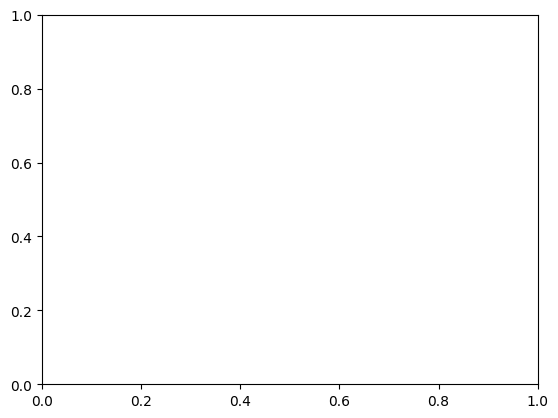

In [ ]:
#Optimize the hyperparameter lambda using 5-fold cross validation
#Use the NMAE as the performance metric
#Plot the NMAE vs lambda curve
#Report the best value of lambda and the corresponding NMAE

max_iter = [10, 30, 50]
lamdas = [6, 6.5, 6.7]
NMAE_list = []
for j in max_iter:
    print(f'max_iter= {j}',end=':: ')
    for lr in lamdas:
        NMAE_list.append(NN_folds(4, lr, j))
        print(f'lr= {lr}',end='; ')
    print()

plt.plot(lamdas, NMAE_list)
plt.xlabel('lambda')
plt.ylabel('NMAE')
plt.show()

In [ ]:
def nuclear_norm_minimization(Y, lambda_, k, p):
    #initialise X
    X = np.random.rand(Y.shape[0], Y.shape[1])
    #Creating R matrix with shape of Y
    R = np.zeros(Y.shape)
    #Now putting 1s in R where Y is not 0
    R[Y!=0] = 1
    #Now iterating k times
    while(k>0):
        #Putting 0 values in R_X where R is 0
        R_X = np.multiply(R, X)
        #Calculate B
        B = X + (Y - R_X)
        U, S, V = np.linalg.svd(B, full_matrices=False)
        S = np.diag(S) 
        # Adjusting singular values using Schatten-Norm, from the given formula in paper
        sch_norm = np.sum(S ** p) ** (1 / p)
        S_ = np.maximum(0, S - ((lambda_/2)*p*(sch_norm**p)))
        
        #Updating X
        X = np.dot(U, np.dot(S_,V))
        k = k-1
    return X

In [78]:
#Calculate NMAE for the users present in the test data
def NMAE(test_data, predicted_matrix):
    test_data = test_data[test_data['rating'] > 0]  
    NMAE = 0
    for line in test_data.itertuples():
        NMAE += abs(line[3] - predicted_matrix[line[1]-1, line[2]-1])
    NMAE = NMAE / len(test_data)
    #Normalise the NMAE by the range of the ratings in the test data and return
    return NMAE / (max(test_data['rating']) - min(test_data['rating'])+3)

In [ ]:
print(NN_folds(4, 8, 10))

NMAE for fold 4 is: 0.563121681721848
0.563121681721848


In [ ]:
NN_folds(4, 6.9, 100)

NMAE for fold 4 is: 0.25224813366040805


0.25224813366040805

## Running for the best Parameters, for all folds

In [ ]:
def nuclear_norm_minimization(Y, lambda_, k):
    #initialise X
    X = np.random.rand(Y.shape[0], Y.shape[1])
    #Creating R matrix with shape of Y
    R = np.zeros(Y.shape)
    #Now putting 1s in R where Y is not 0
    R[Y!=0] = 1
    #Now iterating k times
    while(k>0):
        #Putting 0 values in R_X where R is 0
        R_X = np.multiply(R, X)
        #Calculate B
        B = X + Y - R_X
        U, S, V = np.linalg.svd(B, full_matrices=False)
        S = np.diag(S)
        #Making negative values 0 after subtracting lambda/2
        S = np.maximum(S - 6/2, 0)
        #Updating X
        X = np.dot(U, np.dot(S, V))
        k = k-1
    return X

In [ ]:
#Performing ALS on the 5 fold datasets
def NN_folds(fold_index, lambda_, max_iter):
    #Read the data
    train_data = pd.read_csv(f'ml-100k/u{fold_index}.base', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    test_data = pd.read_csv(f'ml-100k/u{fold_index}.test', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    #Create a matrix of users and items
    train_data_matrix = np.zeros((943, 1682))
    for line in train_data.itertuples():
        train_data_matrix[line[1]-1, line[2]-1] = line[3]
    #Predict the missing values
    predicted_matrix = nuclear_norm_minimization(train_data_matrix, lambda_, max_iter)
    #Calculate NMAE for the users present in the test data
    NMAE_ = NMAE(test_data, predicted_matrix)
    print(f'NMAE for fold {fold_index} is: {NMAE_}')
  
NN_folds(1, 6.9, 150)

NMAE for fold 1 is: 0.2376860394409616


In [ ]:
#Performing ALS on the 5 fold datasets
predicted_matrix = []
predicted_matrix_rounded = []

def NN_folds(fold_index, lambda_, max_iter):
    global predicted_matrix
    global predicted_matrix_rounded
    #Read the data
    train_data = pd.read_csv(f'ml-100k/u{fold_index}.base', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    test_data = pd.read_csv(f'ml-100k/u{fold_index}.test', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    #Create a matrix of users and items
    train_data_matrix = np.zeros((943, 1682))
    for line in train_data.itertuples():
        train_data_matrix[line[1]-1, line[2]-1] = line[3]
    #Predict the missing values
    predicted_matrix = nuclear_norm_minimization(train_data_matrix, lambda_, max_iter)
    predicted_matrix_rounded = np.round(predicted_matrix)
    #Calculate NMAE for the users present in the test data
    NMAE_ = NMAE(test_data, predicted_matrix)
    print(f'NMAE for fold {fold_index} is: {NMAE_}')
  
NN_folds(1, 6.9, 150)

NMAE for fold 1 is: 0.2463337258500167


# Rounded off results to the nearest rating integer

In [ ]:
test_data = pd.read_csv(f'ml-100k/u1.test', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
NMAE_ = NMAE(test_data, predicted_matrix_rounded)
print(f'NMAE for fold 1 is: {NMAE_}')

NMAE for fold 1 is: 0.238625


In [ ]:
#Performing ALS on the 5 fold datasets
predicted_matrix = []
predicted_matrix_rounded = []

def NN_folds(fold_index, lambda_, max_iter):
    global predicted_matrix
    global predicted_matrix_rounded
    #Read the data
    train_data = pd.read_csv(f'ml-100k/u{fold_index}.base', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    test_data = pd.read_csv(f'ml-100k/u{fold_index}.test', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    #Create a matrix of users and items
    train_data_matrix = np.zeros((943, 1682))
    for line in train_data.itertuples():
        train_data_matrix[line[1]-1, line[2]-1] = line[3]
    #Predict the missing values
    predicted_matrix = nuclear_norm_minimization(train_data_matrix, lambda_, max_iter)
    predicted_matrix_rounded = np.round(predicted_matrix)
    #Calculate NMAE for the users present in the test data
    NMAE_ = NMAE(test_data, predicted_matrix)
    print(f'NMAE for fold {fold_index} is: {NMAE_}')

NN_folds(1, 0.1, 50)

NMAE for fold 1 is: 0.369687476676441
